# Libraries

In [1]:
# import all the required libraries

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

# Synthetic Data Generation

In this section, a synthetic dataset is created based on results from the conducted survey.

## Credential Stuffing

- Session duration: Short, usually less than a minute, as bots are attempting to quickly test a large number of stolen credentials.
- Bounce rate: High, as bots are not interested in engaging with the website beyond attempting to log in.
- HTTP request type: POST requests are the most common, as they are used to submit login information.
- Inter-request interval time: Short, as bots are attempting to test as many credentials as possible in a short amount of time.
- Bytes requested: Small, as bots are only submitting login information.
- Browser/OS: No specific pattern, as these attacks are usually automated and can originate from any type of system or device.
- Country: Since credential stuffing attacks use stolen login credentials, the location of the bot may not necessarily match the location of the attacker. However, some studies suggest that credential stuffing attacks often originate from countries with high levels of cybercrime, such as Russia, China, and India.

## Price Scraping
- Session duration: Medium, as bots are interested in gathering as much information as possible about prices and products.
- Bounce rate: Low, as bots are often browsing the website in a similar way to human users.
- HTTP request type: GET requests are the most common, as they are used to retrieve information about products and prices.
- Inter-request interval time: Medium to high, as bots are not in a hurry and may take breaks between requests to avoid detection.
- Bytes requested: Medium, as bots are retrieving product information and prices.
- Browser/OS: No specific pattern, as these attacks are usually automated and can originate from any type of system or device.
- Country: Price scraping bots are often used by competitors looking to gain an edge in the market, so they may originate from a wide range of countries. However, countries with a large number of e-commerce businesses, such as the United States, China, and India, may be more likely to have price scraping bots.

## Inventory Hoarding
- Session duration: Long, as bots are interested in adding and keeping as many items to their cart as possible.
- Bounce rate: Low, as bots are attempting to browse the website in a similar way to human users.
- HTTP request type: POST requests are the most common, as they are used to add items to the cart.
- Inter-request interval time: Medium, as bots are not in a hurry and may take breaks between requests to avoid detection.
- Bytes requested: Medium, as bots are adding items to their cart.
- Browser/OS: No specific pattern, as these attacks are usually automated and can originate from any type of system or device.
- Country: The location of the bot may not match the location of the attacker. However, countries with a large e-commerce market and high demand for popular items, such as the United States, China, and Japan, may be more likely to have inventory hoarding bots.

## Gift Card Fraud

- Session duration: Short, as bots are attempting to quickly test a large number of gift card numbers.
- Bounce rate: Medium to high, as bots are not interested in engaging with the website beyond testing gift card numbers.
- HTTP request type: POST requests are the most common, as they are used to submit gift card information.
- Inter-request interval time: Short, as bots are attempting to test as many gift card numbers as possible in a short amount of time.
- Bytes requested: Small, as bots are only submitting gift card information.
- Browser/OS: No specific pattern, as these attacks are usually automated and can originate from any type of system or device.
- Country: The location of the bot may not necessarily match the location of the attacker, but countries with a large number of e-commerce sites and a high demand for gift cards, such as the United States and Canada, may be more likely to have gift card fraud bots.

## Summary

| Bot Type | Session Duration | Inter-request interval | Bounce Rate | Browser | OS | Request Type | Bytes Requested | JS Enabled |
|-|-|-|-|-|-|-|-|-|
| Credential Stuffing | Short (<60s) | Short (<1s) | High (>90%) | Various | Various | POST | Small (<5KB) | No |
| Price Scraping | Medium (1-5min) | Medium (5-10s) | Low (<30%)| Various | Various | GET | Medium (10-100KB) | No |
| Inventory Hoarding  | Long (5-30min) | Medium (10-20s) | Low (<30%) | Various | Various | POST | Medium/High (100-500KB) | No |
| Gift Card Fraud | short (<60s) | Short (<1s) | Medium/High (>80%) | Various | Various | POST | Small (<5KB) | No |


In [2]:
# set all possible values for the categorical features

N = 100000

browser_list = ['Chrome', 'Firefox', 'Safari', 'Edge', 'IE', 'Opera', 'Unknown']
os_list = ['Windows', 'Linux', 'MacOS', 'iOS', 'Android', 'Unknown']
country_list = ['DE', 'UK', 'FR', 'SP', 'NL', 'US', 'CA', 'AU', 'BR', 'MX', 'IN', 'CH', 'RU']
request_list = ['GET', 'POST']
js_list = [0, 1]
class_list = ['human', 'bot_c', 'bot_p', 'bot_i', 'bot_g']

In [3]:
# encode all feature-related values for bots and humans

dict_visitors = {'human': {'n'        : int(N * 0.70),
                           'session'  : [900, 200],
                           'bounce'   : [15, 2],
                           'w_request': [0.5, 0.5],
                           'inter_req': [30000, 5000],
                           'bytes'    : [15, 2],
                           'w_browser': [0.35, 0.15, 0.25, 0.05, 0.03, 0.02, 0.15],
                           'w_os'     : [0.20, 0.05, 0.15, 0.25, 0.25, 0.10],
                           'w_country': [0.80, 0.04, 0.02, 0.02, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
                           'w_js'     : [0.1, 0.9],
                           'class'    : [0.9, 0.025, 0.025, 0.025, 0.025]},
                 'noise_1': {'n'      : int(N * 0.05),
                           'session'  : [1800, 300],
                           'bounce'   : [10, 2],
                           'w_request': [0.5, 0.5],
                           'inter_req': [30000, 5000],
                           'bytes'    : [300, 100],
                           'w_browser': [0.35, 0.15, 0.25, 0.05, 0.03, 0.02, 0.15],
                           'w_os'     : [0.20, 0.05, 0.15, 0.25, 0.25, 0.10],
                           'w_country': [0.80, 0.04, 0.02, 0.02, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
                           'w_js'     : [0.5, 0.5],
                           'class'    : [0.9, 0.025, 0.025, 0.025, 0.025]},
                 'noise_2': {'n'      : int(N * 0.05),
                           'session'  : [60, 20],
                           'bounce'   : [90, 2],
                           'w_request': [0.5, 0.5],
                           'inter_req': [1500, 100],
                           'bytes'    : [30, 5],
                           'w_browser': [0.35, 0.15, 0.25, 0.05, 0.03, 0.02, 0.15],
                           'w_os'     : [0.20, 0.05, 0.15, 0.25, 0.25, 0.10],
                           'w_country': [0.80, 0.04, 0.02, 0.02, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
                           'w_js'     : [0.5, 0.5],
                           'class'    : [0.9, 0.025, 0.025, 0.025, 0.025]},
                 'bot_c': {'n'        : int(N * 0.03),
                           'session'  : [40, 10],
                           'bounce'   : [90, 10],
                           'w_request': [0, 1],
                           'inter_req': [400, 100],
                           'bytes'    : [20, 5],
                           'w_browser': [0.02, 0.02, 0, 0, 0.01, 0, 0.95],
                           'w_os'     : [0.01, 0.04, 0, 0, 0, 0.95],
                           'w_country': [0.10, 0.01, 0.02, 0.03, 0.01, 0.05, 0.03, 0.01, 0.02, 0.02, 0.25, 0.25, 0.20],
                           'w_js'     : [0.95, 0.05],
                           'class'    : [0.025, 0.9, 0.025, 0.025, 0.025]},
                 'bot_p': {'n'        : int(N * 0.10),
                           'session'  : [180, 60],
                           'bounce'   : [25, 5],
                           'w_request': [1, 0],
                           'inter_req': [7000, 2000],
                           'bytes'    : [60, 10],
                           'w_browser': [0.02, 0.02, 0, 0, 0.01, 0, 0.95],
                           'w_os'     : [0.01, 0.04, 0, 0, 0, 0.95],
                           'w_country': [0.10, 0.01, 0.02, 0.03, 0.01, 0.05, 0.03, 0.01, 0.02, 0.02, 0.25, 0.25, 0.20],
                           'w_js'     : [0.95, 0.05],
                           'class'    : [0.025, 0.025, 0.9, 0.025, 0.025]},
                 'bot_i': {'n'        : int(N * 0.05),
                           'session'  : [1800, 300],
                           'bounce'   : [20, 5],
                           'w_request': [0, 1],
                           'inter_req': [15000, 5000],
                           'bytes'    : [400, 100],
                           'w_browser': [0.02, 0.02, 0, 0, 0.01, 0, 0.95],
                           'w_os'     : [0.01, 0.04, 0, 0, 0, 0.95],
                           'w_country': [0.10, 0.01, 0.02, 0.03, 0.01, 0.05, 0.03, 0.01, 0.02, 0.02, 0.25, 0.25, 0.20],
                           'w_js'     : [0.95, 0.05],
                           'class'    : [0.025, 0.025, 0.025, 0.9, 0.025]},
                 'bot_g': {'n'        : int(N * 0.02),
                           'session'  : [60, 10],
                           'bounce'   : [50, 10],
                           'w_request': [0, 1],
                           'inter_req': [1500, 300],
                           'bytes'    : [15, 5],
                           'w_browser': [0.02, 0.02, 0, 0, 0.01, 0, 0.95],
                           'w_os'     : [0.01, 0.04, 0, 0, 0, 0.95],
                           'w_country': [0.10, 0.01, 0.02, 0.03, 0.01, 0.05, 0.03, 0.01, 0.02, 0.02, 0.25, 0.25, 0.20],
                           'w_js'     : [0.95, 0.05],
                           'class'    : [0.025, 0.025, 0.025, 0.025, 0.9]}}


In [4]:
# create the synthetic dataset based on the values in the dictionary

rows = []

for k in dict_visitors.keys():

    for i in range(dict_visitors[k]['n']):

        session_duration = int(random.gauss(dict_visitors[k]['session'][0], dict_visitors[k]['session'][1]))
        bounce_rate = int(random.gauss(dict_visitors[k]['bounce'][0], dict_visitors[k]['bounce'][1]))
        request_type = random.choices(request_list, weights=dict_visitors[k]['w_request'])[0]
        inter_request_time = int(random.gauss(dict_visitors[k]['inter_req'][0], dict_visitors[k]['inter_req'][1]))
        bytes_requested = int(random.gauss(dict_visitors[k]['bytes'][0], dict_visitors[k]['bytes'][1]))
        browser = random.choices(browser_list, weights=dict_visitors[k]['w_browser'])[0]
        os = random.choices(os_list, weights=dict_visitors[k]['w_os'])[0]
        country = random.choices(country_list, weights=dict_visitors[k]['w_country'])[0]
        js = random.choices(js_list, weights=dict_visitors[k]['w_js'])[0]
        label = random.choices(class_list, weights=dict_visitors[k]['class'])[0]

        row = [session_duration, bounce_rate, request_type, inter_request_time,
               bytes_requested, browser, os, country, js, label]
        rows.append(row)

In [5]:
# create a dataframe from the dataset

df = pd.DataFrame(rows,
                  columns=['session_duration',
                           'bounce_rate',
                           'request_type',
                           'inter_request_time',
                           'bytes_requested',
                           'browser',
                           'os',
                           'country',
                           'js',
                           'class'])
df

,session_duration,bounce_rate,request_type,inter_request_time,bytes_requested,browser,os,country,js,class
0,971,15,GET,36072,15,Safari,Android,DE,1,human
1,1060,13,POST,31173,17,Safari,Windows,UK,1,bot_i
2,1234,12,GET,34667,15,Firefox,iOS,DE,1,human
3,1057,13,GET,31078,15,Chrome,iOS,DE,1,human
4,909,16,GET,35492,14,Firefox,MacOS,DE,0,human
...,...,...,...,...,...,...,...,...,...,...
99995,53,55,POST,1324,14,Unknown,Unknown,US,0,bot_g
99996,51,46,POST,1501,10,Unknown,Unknown,IN,0,bot_g
99997,66,35,POST,1429,20,Unknown,Unknown,CH,0,bot_g
99998,48,38,POST,1828,13,Unknown,Linux,IN,0,bot_g


In [6]:
# shuffle the dataset based on rows

df = df.sample(frac=1).reset_index(drop=True)
df

,session_duration,bounce_rate,request_type,inter_request_time,bytes_requested,browser,os,country,js,class
0,1073,16,POST,26726,13,Safari,iOS,DE,1,human
1,896,15,POST,37166,14,Unknown,MacOS,DE,1,human
2,642,14,GET,27585,13,Unknown,Android,DE,1,human
3,905,18,POST,31566,18,Chrome,Linux,DE,1,human
4,973,15,GET,21097,14,Chrome,Android,DE,0,human
...,...,...,...,...,...,...,...,...,...,...
99995,991,17,POST,24906,15,Safari,MacOS,DE,1,human
99996,63,89,GET,1581,32,Chrome,Android,DE,1,human
99997,1780,15,POST,17990,569,Unknown,Unknown,RU,0,bot_i
99998,1773,21,POST,15063,258,Unknown,Unknown,FR,0,bot_i


# Exploratory Data Analysis (EDA)

In [7]:
# print general info about the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   session_duration    100000 non-null  int64 
 1   bounce_rate         100000 non-null  int64 
 2   request_type        100000 non-null  object
 3   inter_request_time  100000 non-null  int64 
 4   bytes_requested     100000 non-null  int64 
 5   browser             100000 non-null  object
 6   os                  100000 non-null  object
 7   country             100000 non-null  object
 8   js                  100000 non-null  int64 
 9   class               100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [8]:
# output statistical summary on numeric columns

df.describe()

,session_duration,bounce_rate,inter_request_time,bytes_requested,js
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,831.931050,22.220280,24066.964110,53.548210,0.690920
std,486.477246,20.980831,11503.089818,106.042018,0.462117
min,-29.000000,2.000000,-2648.000000,-83.000000,0.000000
25%,607.000000,13.000000,19073.000000,14.000000,0.000000
50%,863.000000,15.000000,27843.500000,15.000000,1.000000
75%,1056.000000,18.000000,32128.000000,24.000000,1.000000
max,2957.000000,124.000000,54222.000000,751.000000,1.000000


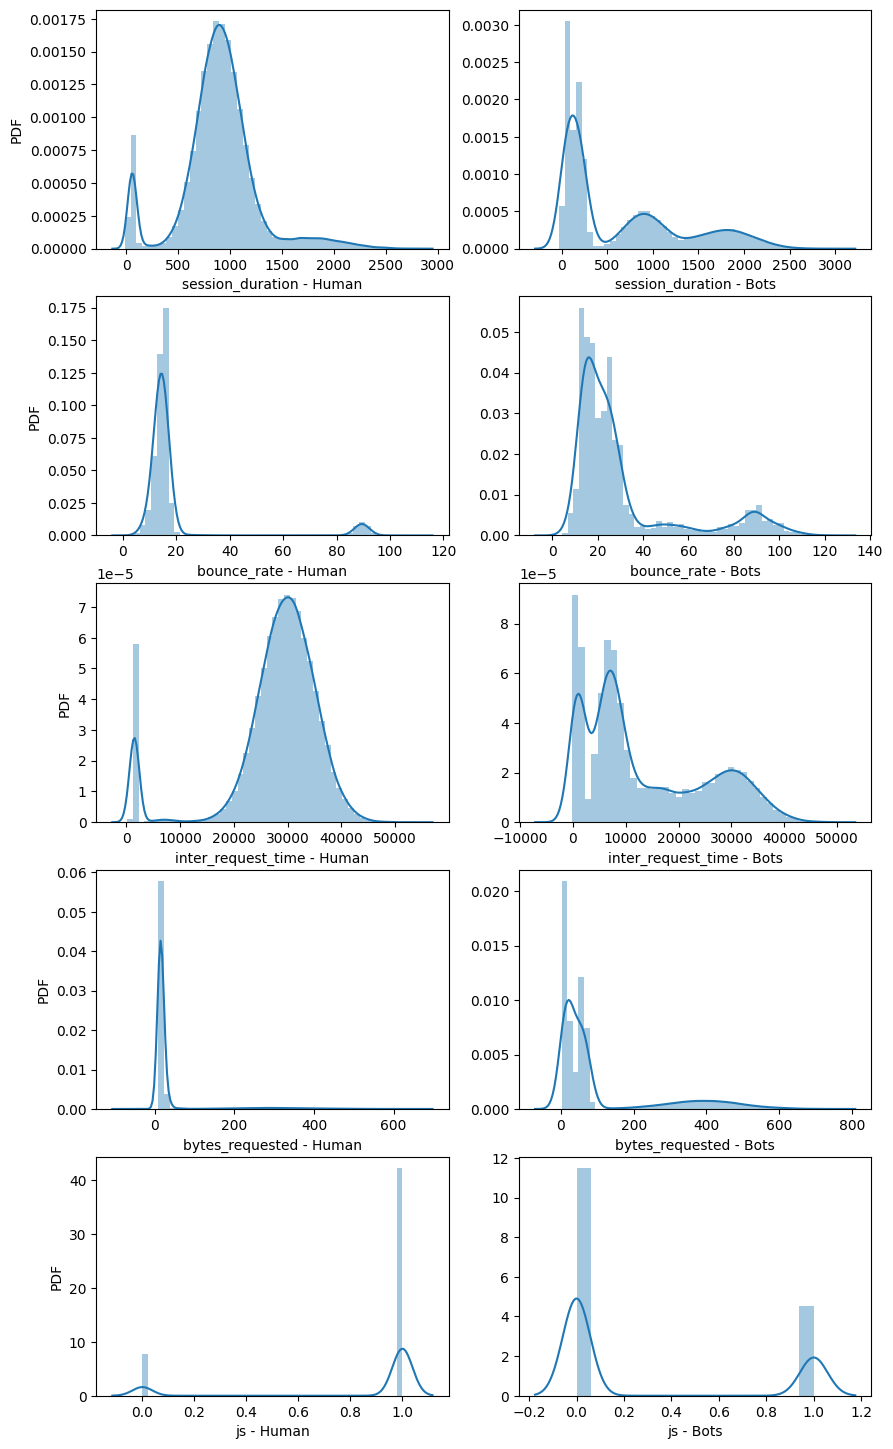

In [9]:
# plot the probability density for numeric columns

df_num = df.select_dtypes(include=['number'])
df_num['class'] = df['class']
i=1
plt.figure(figsize=(10,18))
for col in df_num.columns[:-1]:
    plt.subplot(5,2,i)
    sns.distplot(df_num.loc[df_num['class']=='human', col], kde=True)
    plt.xlabel(f'{col} - Human')
    plt.ylabel('PDF')
    plt.subplot(5,2,i+1)
    sns.distplot(df_num.loc[df_num['class']!='human', col], kde=True)
    plt.xlabel(f'{col} - Bots')
    plt.ylabel('')
    i+=2

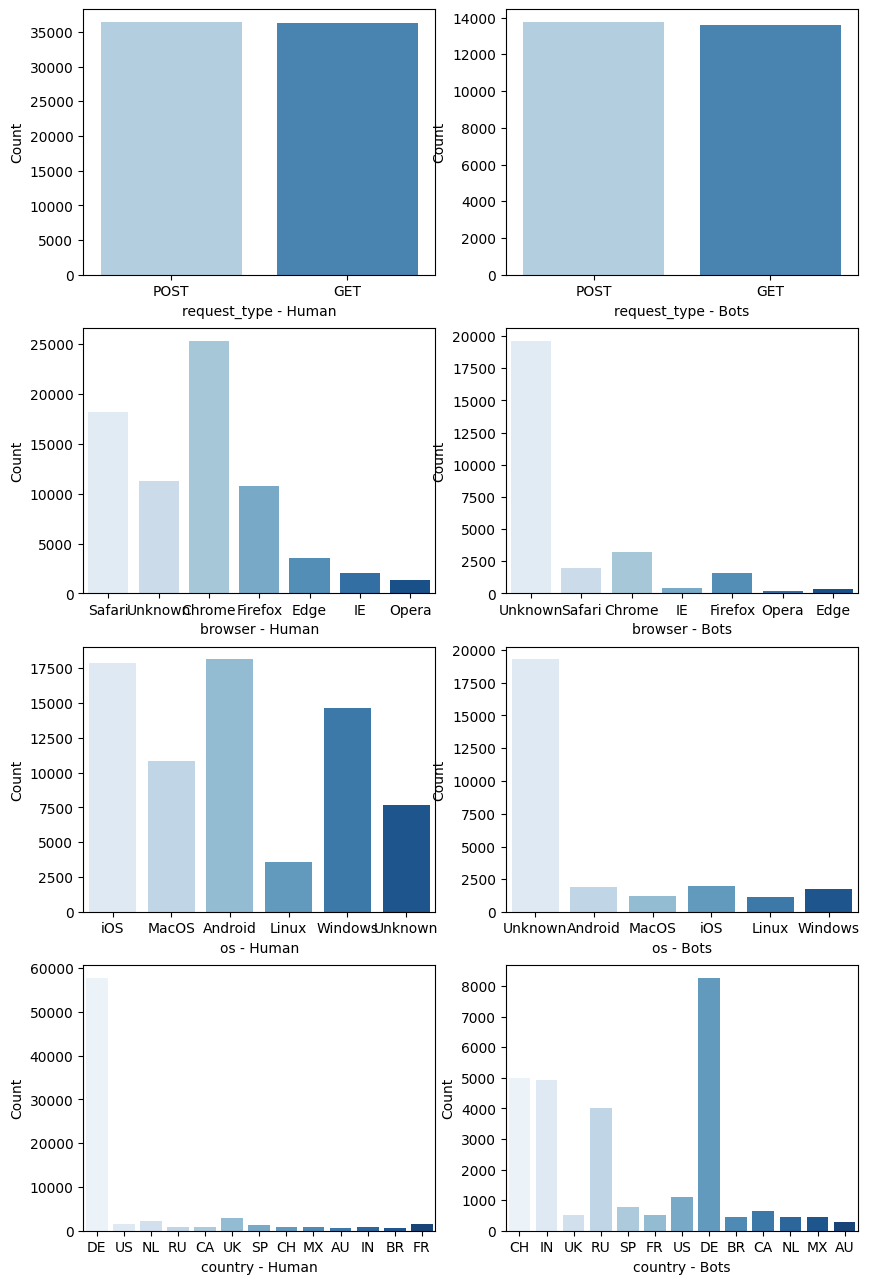

In [10]:
# plot the distribution for categorical columns

df_cat = df.select_dtypes(exclude=['number'])
df_cat['class'] = df['class']
i=1
plt.figure(figsize=(10,20))
for col in df_cat.columns[:-1]:
    plt.subplot(5,2,i)
    sns.countplot(df_cat.loc[df_cat['class']=='human'], x=col, palette='Blues')
    plt.xlabel(f'{col} - Human')
    plt.ylabel('Count')
    plt.subplot(5,2,i+1)
    sns.countplot(df_cat.loc[df_cat['class']!='human'], x=col, palette='Blues')
    plt.xlabel(f'{col} - Bots')
    plt.ylabel('Count')
    i+=2

<Axes: >

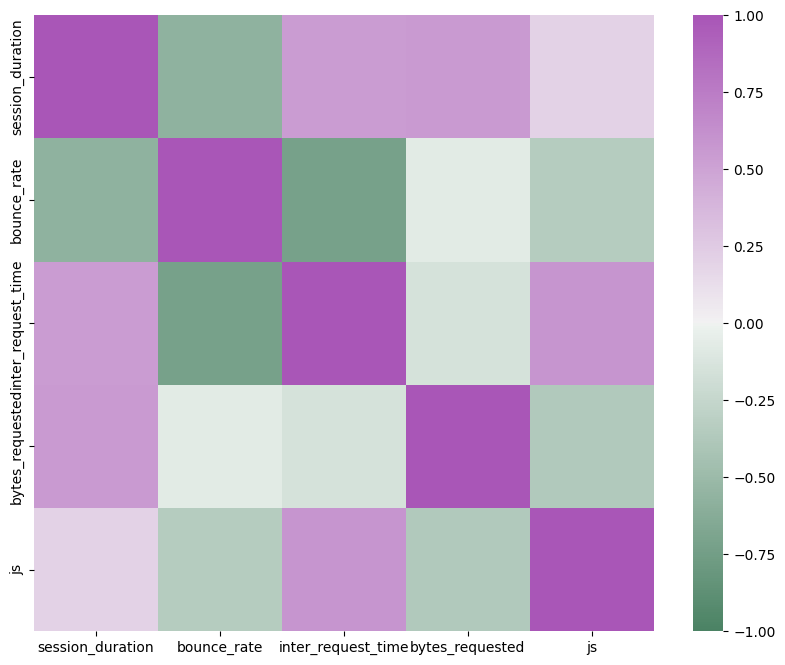

In [11]:
# plot the correlation heatmap for numeric columns

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), ax=ax, vmin=-1,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))

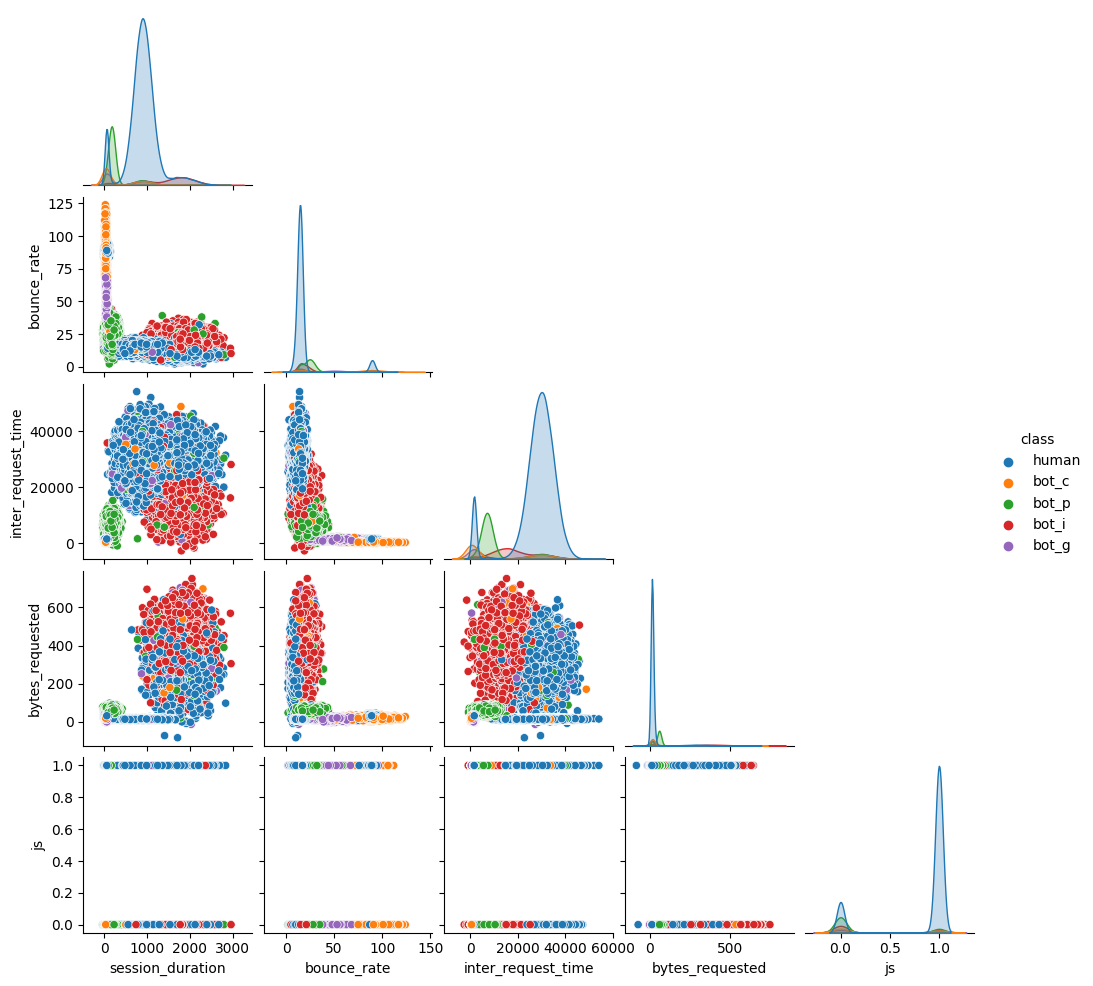

In [12]:
sns.pairplot(df, hue='class', corner=True, height=2)

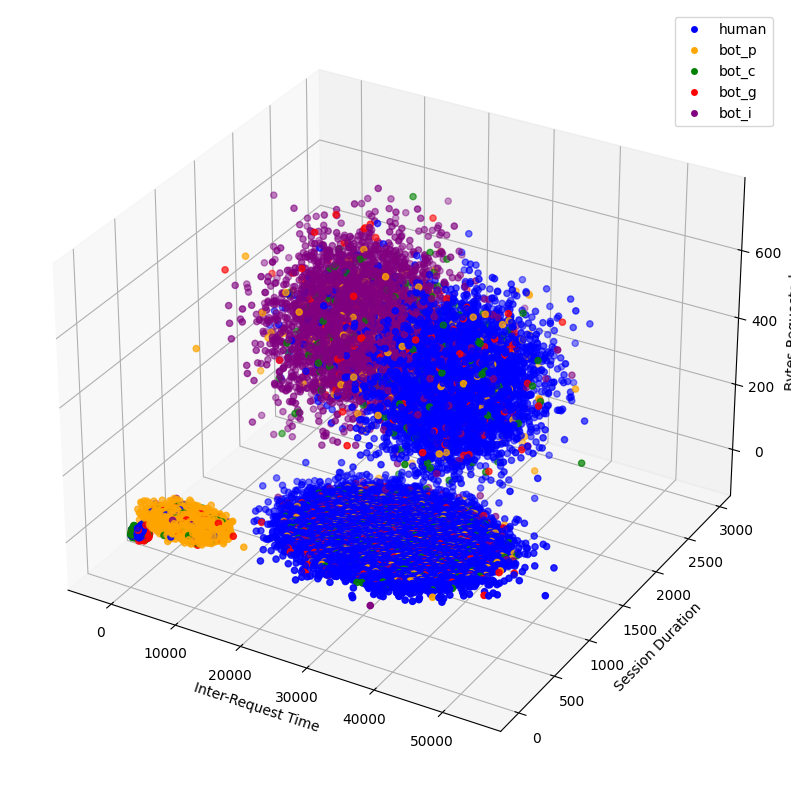

In [13]:
# visualize class in top 3 dimensions

from mpl_toolkits.mplot3d import Axes3D

colors = df['class'].replace({'human':'blue', 'bot_p':'orange', 'bot_c':'green', 'bot_g':'red', 'bot_i':'purple'}).values
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['inter_request_time'], df['session_duration'], df['bytes_requested'], c=colors)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color)
                   for label, color in [('human','blue'), ('bot_p','orange'), ('bot_c','green'), ('bot_g','red'), ('bot_i','purple')]]
ax.legend(handles=legend_elements, loc='best')
ax.set_xlabel('Inter-Request Time')
ax.set_ylabel('Session Duration')
ax.set_zlabel('Bytes Requested')
plt.show()

# Feature Engineering

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# function to one hot encode the columns of a data frame
def onehot_encoder(df, col_list):

    o = OneHotEncoder()
    c = [[i] for i in col_list]
    for i in range(len(c)):
        # print(c[i])
        t = o.fit_transform(df[c[i]])
        df[o.categories_[0]] = t.toarray()
        df.drop(col_list[i], axis=1, inplace=True)

# function to label encode the target column of a data frame
def label_encoder(df, col_list):

    l = LabelEncoder()
    c = [[i] for i in col_list]
    for i in range(len(c)):
        t = l.fit_transform(df[c[i]])
        df.drop(col_list[i], axis=1, inplace=True)
        df[col_list[i]] = t

In [15]:
df_proc = df.copy()
onehot_encoder(df_proc, ['request_type', 'browser', 'os', 'country'])
label_encoder(df_proc, ['class'])
df_proc.head(5)

,session_duration,bounce_rate,inter_request_time,bytes_requested,js,GET,POST,Chrome,Edge,Firefox,...,DE,FR,IN,MX,NL,RU,SP,UK,US,class
0,1073,16,26726,13,1,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,896,15,37166,14,1,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,642,14,27585,13,1,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,905,18,31566,18,1,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,973,15,21097,14,0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [16]:
X = df_proc.drop('class', axis=1)
Y = df_proc['class']
XY = pd.concat([X, Y], axis=1)

scaler_st = StandardScaler()
X_st = pd.DataFrame(scaler_st.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_st, Y, test_size=0.2, random_state=1)

In [17]:
scaler_st = StandardScaler()
X_st = pd.DataFrame(scaler_st.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_st, Y, test_size=0.2, random_state=1)

# Classification + Hyperparameter Optimization

In [18]:
# function to be used for all models - calculate all metrics

def calc_result(model, X_train, y_train, X_test, y_test, hinge=False):

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    conf_train = confusion_matrix(y_train, y_train_pred)
    print(' Training set metrics '.center(60, '-'))
    print('Accuracy:'.ljust(8), round(accuracy_train*100, 2), '%')
    print('Confusion Matrix:\n', conf_train, '\n')
    print('Classification Report:\n', classification_report(y_train, y_train_pred, target_names=['bot_c', 'bot_g', 'bot_i', 'bot_p', 'human']))

    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    conf_test = confusion_matrix(y_test, y_test_pred)
    print(' Testing set metrics '.center(60, '-'))
    print('Accuracy:'.ljust(8), round(accuracy_test*100, 2), '%')
    print('Confusion Matrix:\n', conf_test, '\n')
    print('Classification Report:\n', classification_report(y_test, y_test_pred, target_names=['bot_c', 'bot_g', 'bot_i', 'bot_p', 'human']))

    if hinge:
        calibrator = CalibratedClassifierCV(model, cv='prefit')
        model = calibrator.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(5):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    mean_tpr /= 5

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4)

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        

In [ ]:
linestyle=":",
        linewidth=4)

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(5), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],


In [ ]:
            y_score[:, class_id],
            name=f"ROC curve for {['Bot-C', 'Bot-P','Bot-I','Bot-G','Human'][class_id]}",
            color=color,
            ax=ax)

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()

    res_list = [accuracy_train, conf_train, accuracy_test, conf_test, y_test_pred]
    return res_list


# function to do grid search and find the best hyperparameter

def optimize_params(model, X, Y, params={}):

        grid = GridSearchCV(model, params, cv=5)
        grid.fit(X, Y)
        print('Optimal parameters:', grid.best_params_, '\n')
        return grid.best_params_


# create a k-fold cross-validator function

def kfold_cv(model, X, Y, k=5):

    results_dict = cross_val_score(model, X, Y, cv=k)
    df = pd.DataFrame(results_dict, columns=['Accuracy'])
    print(f'avg. accuracy across 5 folds: {100*round(df.mean().values[0], 2)}%\n')


## SVM

------------------- Training set metrics -------------------
Accuracy: 89.86 %
Confusion Matrix:
 [[ 2084    79   105   194  1611]
 [   95  1388    93   205  1620]
 [   65    46  3503   185  1525]
 [   60    34   115  7178  1604]
 [   92    31   124   232 57732]] 

Classification Report:
               precision    recall  f1-score   support

       bot_c       0.87      0.51      0.64      4073
       bot_g       0.88      0.41      0.56      3401
       bot_i       0.89      0.66      0.76      5324
       bot_p       0.90      0.80      0.85      8991
       human       0.90      0.99      0.94     58211

    accuracy                           0.90     80000
   macro avg       0.89      0.67      0.75     80000
weighted avg       0.90      0.90      0.89     80000

------------------- Testing set metrics --------------------
Accuracy: 89.92 %
Confusion Matrix:
 [[  542    21    20    53   380]
 [   31   352    28    50   411]
 [    8     8   952    53   413]
 [   10     8    20  179

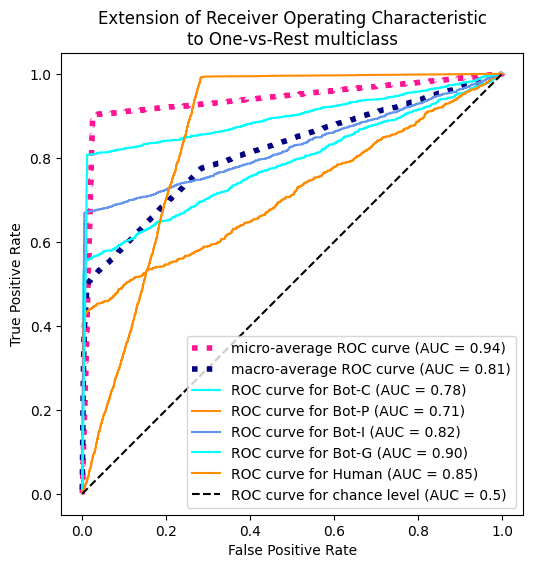

In [ ]:
from sklearn.svm import SVC

# params_SVM = {'C': [0.1, 1], 'gamma': [0.1, 1]}
# param_opt = optimize_params(SVC(), X_st, Y, params_SVM)

m_SVM = SVC(probability=True) # C=param_opt['C'], gamma=param_opt['gamma']
res_m_SVM = calc_result(m_SVM, X_train, y_train, X_test, y_test)
kfold_cv(m_SVM, X_st, Y)

## Stochastic Gradient Descent

Optimal parameters: {'alpha': 0.001} 

------------------- Training set metrics -------------------
Accuracy: 87.3 %
Confusion Matrix:
 [[ 1717     1   117   241  2069]
 [  503    13   242   851  1825]
 [   74     0  3627   244  1632]
 [   65     3   101  7161  1684]
 [   67     0   210   232 57321]] 

Classification Report:
               precision    recall  f1-score   support

       bot_c       0.71      0.41      0.52      4145
       bot_g       0.76      0.00      0.01      3434
       bot_i       0.84      0.65      0.73      5577
       bot_p       0.82      0.79      0.81      9014
       human       0.89      0.99      0.94     57830

    accuracy                           0.87     80000
   macro avg       0.81      0.57      0.60     80000
weighted avg       0.86      0.87      0.85     80000

------------------- Testing set metrics --------------------
Accuracy: 87.96 %
Confusion Matrix:
 [[  420     1    25    60   490]
 [  110     2    49   221   466]
 [   13     0   889

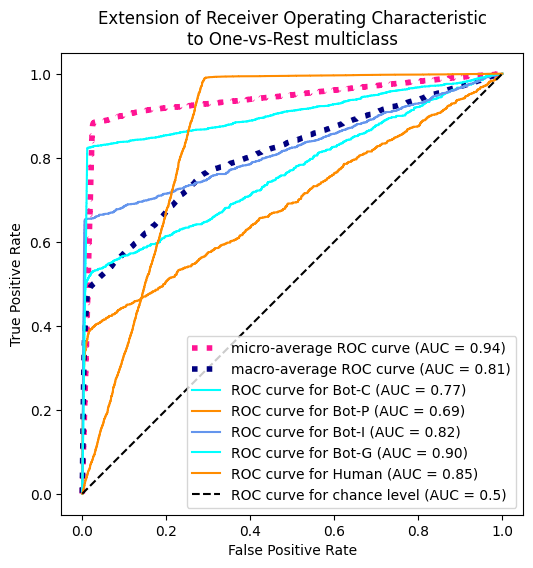

avg. accuracy across 5 folds: 88.0%



In [ ]:
params_SGD = {'alpha': [0.001, 0.01, 0.1]}
param_opt = optimize_params(SGDClassifier(), X_st, Y, params_SGD)

m_SGD = SGDClassifier(alpha=param_opt['alpha'])
res_m_SGD = calc_result(m_SGD, X_train, y_train, X_test, y_test, hinge=True)
kfold_cv(m_SGD, X_st, Y)

## Random Forest

Optimal parameters: {'max_depth': 5} 

------------------- Training set metrics -------------------
Accuracy: 89.6 %
Confusion Matrix:
 [[ 2133    45   108   222  1637]
 [   83  1404    88   193  1666]
 [   75    47  3579   220  1656]
 [   68    22    97  7152  1675]
 [   64    42   109   202 57413]] 

Classification Report:
               precision    recall  f1-score   support

       bot_c       0.88      0.51      0.65      4145
       bot_g       0.90      0.41      0.56      3434
       bot_i       0.90      0.64      0.75      5577
       bot_p       0.90      0.79      0.84      9014
       human       0.90      0.99      0.94     57830

    accuracy                           0.90     80000
   macro avg       0.89      0.67      0.75     80000
weighted avg       0.90      0.90      0.89     80000

------------------- Testing set metrics --------------------
Accuracy: 90.14 %
Confusion Matrix:
 [[  517     7    21    58   393]
 [   15   336    24    49   424]
 [   13     6   874

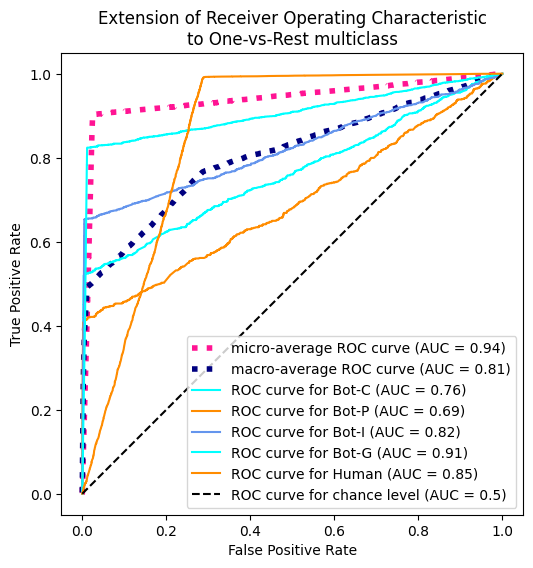

avg. accuracy across 5 folds: 90.0%



In [ ]:
params_RF = {'max_depth': [2, 3, 4, 5]}
param_opt = optimize_params(RandomForestClassifier(), X_st, Y, params_RF)

m_RF = RandomForestClassifier(max_depth=param_opt['max_depth'])
res_m_RF = calc_result(m_RF, X_train, y_train, X_test, y_test)
kfold_cv(m_RF, X_st, Y)

Text(0.5, 0, 'Feature Importance')

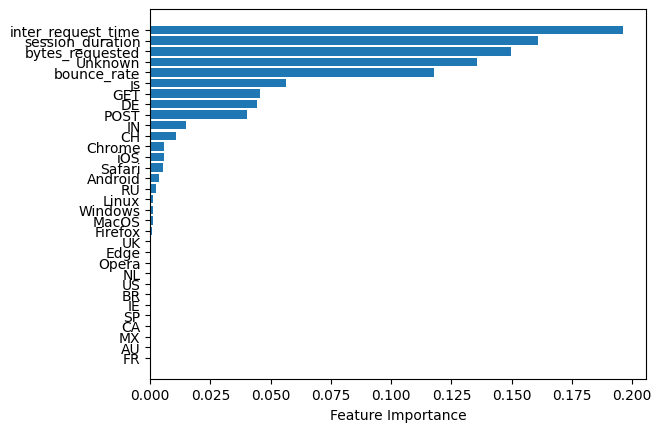

In [ ]:
feature_sort = m_RF.feature_importances_.argsort()
plt.barh(X_st.columns[feature_sort], m_RF.feature_importances_[feature_sort])
plt.xlabel("Feature Importance")

## Decision Tree

Optimal parameters: {'max_depth': 5} 

------------------- Training set metrics -------------------
Accuracy: 89.4 %
Confusion Matrix:
 [[ 2137    47   109   214  1638]
 [   79  1459    93   188  1615]
 [   75    48  3527   213  1714]
 [   68    22    97  7019  1808]
 [   65    37   154   197 57377]] 

Classification Report:
               precision    recall  f1-score   support

       bot_c       0.88      0.52      0.65      4145
       bot_g       0.90      0.42      0.58      3434
       bot_i       0.89      0.63      0.74      5577
       bot_p       0.90      0.78      0.83      9014
       human       0.89      0.99      0.94     57830

    accuracy                           0.89     80000
   macro avg       0.89      0.67      0.75     80000
weighted avg       0.89      0.89      0.88     80000

------------------- Testing set metrics --------------------
Accuracy: 89.9 %
Confusion Matrix:
 [[  517     7    20    58   394]
 [   14   348    24    49   413]
 [   13     6   860 

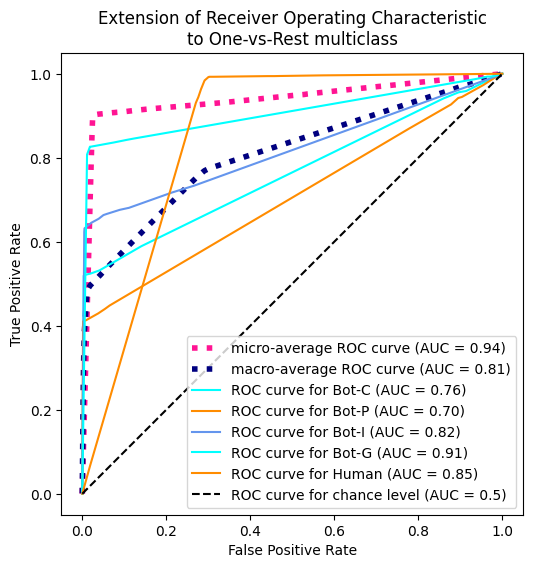

avg. accuracy across 5 folds: 89.0%



In [ ]:
params_DT = {'max_depth': [2, 3, 4, 5]}
param_opt = optimize_params(DecisionTreeClassifier(), X_st, Y, params_DT)

m_DT = DecisionTreeClassifier(max_depth=param_opt['max_depth'])
res_m_DT = calc_result(m_DT, X_train, y_train, X_test, y_test)
kfold_cv(m_DT, X_st, Y)

Text(0.5, 0, 'Feature Importance')

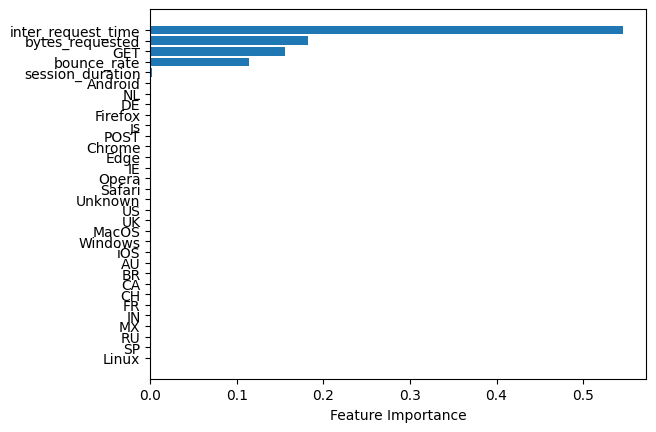

In [ ]:
feature_sort = m_DT.feature_importances_.argsort()
plt.barh(X_st.columns[feature_sort], m_DT.feature_importances_[feature_sort])
plt.xlabel("Feature Importance")